In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from vaemols.models import VariationalAutoencoder
from vaemols.utils.utils import labels_to_smiles

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import logging

logging.basicConfig(level=logging.INFO)

char_data = np.load('data/char_data.npz')
int_to_char = char_data['int_to_char'].item()
char_to_int = char_data['char_to_int'].item()
num_classes = len(char_to_int)

max_length = 120

num_data = 50000

input_data_labeled = np.load('data/x_train.npy')[:num_data]

restore_model_dir = 'saved_models/'
restore_model_path = tf.train.latest_checkpoint(restore_model_dir)
logging.info(restore_model_path)

INFO:root:saved_models/weights-17-274.7396.ckpt


In [2]:
latent_dim = 256
inputs = tf.keras.layers.Input(shape=(max_length, num_classes))
vae = VariationalAutoencoder(latent_dim, num_classes, max_length, num_samples=1)
outputs = vae(inputs)

sess = tf.Session()
with sess.as_default():
    vae.load_weights(restore_model_path)

In [3]:
batch_size = 64
num_batch = len(input_data_labeled)//batch_size + 1

z_mean = np.concatenate([sess.run(vae.z_mean, 
                                  feed_dict={vae.input:tf.keras.utils.to_categorical(
                                      input_data_labeled[i*batch_size:(i+1)*batch_size], num_classes=num_classes)})
                         for i in range(num_batch)], axis=0)

In [4]:
pca = PCA(n_components = 10)
latent_pca = pca.fit_transform(z_mean)

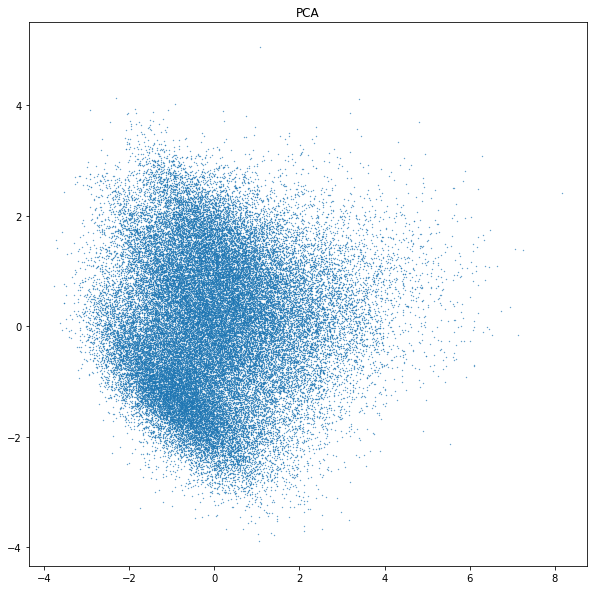

In [5]:
plt.figure(1, figsize = (10, 10))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s = 0.1)
plt.title('PCA')
plt.show()

In [6]:
tensorboard_data_dir = 'tensorboard_data/'

input_data_labeled = input_data_labeled[:10000]
batch_size = 64
num_batch = len(input_data_labeled)//batch_size + 1

z_mean = np.concatenate([sess.run(vae.z_mean, 
                                  feed_dict={vae.input:tf.keras.utils.to_categorical(
                                      input_data_labeled[i*batch_size:(i+1)*batch_size], num_classes=num_classes)})
                         for i in range(num_batch)], axis=0)

In [7]:
smiles = labels_to_smiles(np.squeeze(input_data_labeled), int_to_char)
metadata_path = 'smiles.tsv'
pd.DataFrame(smiles).to_csv(tensorboard_data_dir + metadata_path, sep='\t', header=['smiles'])

In [8]:
latent = tf.Variable(initial_value=z_mean, name='latent')
sess.run(latent.initializer)
tf.train.Saver([latent]).save(sess, tensorboard_data_dir + 'latent.ckpt')
summary_writer = tf.summary.FileWriter(tensorboard_data_dir)
config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name =latent.name
embedding.metadata_path = metadata_path
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(summary_writer, config)

In [ ]:
#tensorboard  --logdir=tensorboard_data